# Capstone Project 1
## Bitcoin(BTC) and Litecoin(LTC) Prices vs Their Google Keyword Search Trend. 

This project will explore the relationship between the closing price of two popular cryptocurrencies (bitcoin(BTC) and litecoin(LTC)) and the frequency of the Google search terms "bitcoin price" and "litecoin price" respectively. The price data will be pulled from Coinbase using the "crycompare" python library.  This uses the Coinbase API to pull the most up-to-date coin information.  The Google search trend data will be obtained using the "pytrends" python library.  This uses some unofficial Google APIs to query the relative frequency, by week, of specific search terms.  Once all the data is in memory and cleaned, trends and coorelations are explored in further detail.



In [1]:
%load_ext autoreload
%autoreload 2

#
# Imports.
#
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
import operator
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from scipy import stats

from crycompare import *

%matplotlib inline

In [47]:
#
# Obtain the price history (close, high, low, open) for bitcoin (BTC) using the crycompare library.
#
h = History()
btc_hist = h.histoDay('BTC', 'USD', allData=True)
if btc_hist['Data']:
    df_btc = pd.DataFrame(btc_hist['Data'])
    df_btc['time'] = pd.to_datetime(df_btc['time'], unit='s')
    df_btc.index = df_btc['time']
    del df_btc['time']
    
#
# Print the first 10 entries.
#
df_btc.head(10)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902
2010-07-18,0.08584,0.08585,0.05941,0.04951,75.01,5.0900
2010-07-19,0.08080,0.09307,0.07723,0.08584,574.00,49.6600
2010-07-20,0.07474,0.08181,0.07426,0.08080,262.00,20.5900
2010-07-21,0.07921,0.07921,0.06634,0.07474,575.00,42.2600
2010-07-22,0.05050,0.08181,0.05050,0.07921,2160.00,129.7800
2010-07-23,0.06262,0.06767,0.05050,0.05050,2402.50,141.0700
2010-07-24,0.05454,0.06161,0.05049,0.06262,496.32,26.7300
2010-07-25,0.05050,0.05941,0.05050,0.05454,1551.48,85.0600


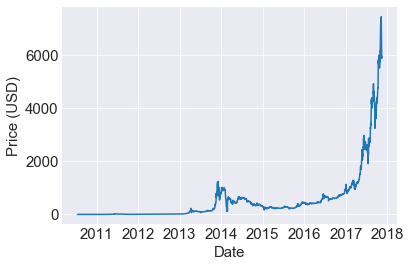

In [49]:
#
# Plot the closing price of bitcoin over time.
#
sns.set_style("darkgrid")
plt.plot(df_btc.close)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [50]:
#
# Obtain the price history (close, high, low, open) for litecoin (LTC) using the crycompare library.
#
ltc_hist = h.histoDay('LTC', 'USD', allData=True)
if ltc_hist['Data']:
    df_ltc = pd.DataFrame(ltc_hist['Data'])
    df_ltc['time'] = pd.to_datetime(df_ltc['time'], unit='s')
    df_ltc.index = df_ltc['time']
    del df_ltc['time']
 
    
#
# Print the first 10 entries.
#
df_ltc.head(10)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-10-24,3.0,3.0,3.0,3.0,2.71,8.12
2013-10-25,3.0,3.0,3.0,3.0,0.00,0.00
2013-10-26,3.0,3.0,3.0,3.0,0.00,0.00
2013-10-27,3.0,3.0,3.0,3.0,0.00,0.00
2013-10-28,3.0,3.0,3.0,3.0,0.00,0.00
2013-10-29,3.0,3.0,3.0,3.0,0.00,0.00
2013-10-30,3.0,3.0,3.0,3.0,0.00,0.00
2013-10-31,3.0,3.0,3.0,3.0,0.00,0.00
2013-11-01,3.0,3.0,3.0,3.0,0.00,0.00


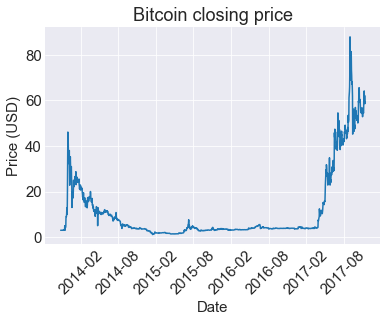

In [51]:
#
# Plot the closing price of litecoin over time.
#
sns.set_style("darkgrid")
plt.plot(df_ltc.close)
plt.xticks(rotation=45)
plt.title("Bitcoin closing price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [52]:
#
# Merge bitcoin and litecoin into a single dataframe.
#
df_coins = pd.concat([df_btc, df_ltc], axis=1)
df_coins.columns = ['btc_close','btc_high','btc_low','btc_open','btc_volfrom','btc_volto','ltc_close','ltc_high', \
                    'ltc_low','ltc_open','ltc_volfrom','ltc_volto']

#
# Print the first 10 entries.
#
df_coins.head(10)

,btc_close,btc_high,btc_low,btc_open,btc_volfrom,btc_volto,ltc_close,ltc_high,ltc_low,ltc_open,ltc_volfrom,ltc_volto
time,,,,,,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-18,0.08584,0.08585,0.05941,0.04951,75.01,5.0900,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-19,0.08080,0.09307,0.07723,0.08584,574.00,49.6600,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,0.07474,0.08181,0.07426,0.08080,262.00,20.5900,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.07921,0.07921,0.06634,0.07474,575.00,42.2600,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-22,0.05050,0.08181,0.05050,0.07921,2160.00,129.7800,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-23,0.06262,0.06767,0.05050,0.05050,2402.50,141.0700,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-24,0.05454,0.06161,0.05049,0.06262,496.32,26.7300,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-25,0.05050,0.05941,0.05050,0.05454,1551.48,85.0600,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
#
# Print the dataframe info.
#
df_coins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2677 entries, 2010-07-17 to 2017-11-13
Freq: D
Data columns (total 12 columns):
btc_close      2677 non-null float64
btc_high       2677 non-null float64
btc_low        2677 non-null float64
btc_open       2677 non-null float64
btc_volfrom    2677 non-null float64
btc_volto      2677 non-null float64
ltc_close      1482 non-null float64
ltc_high       1482 non-null float64
ltc_low        1482 non-null float64
ltc_open       1482 non-null float64
ltc_volfrom    1482 non-null float64
ltc_volto      1482 non-null float64
dtypes: float64(12)
memory usage: 271.9 KB


### From the dataframe info, we can see that there are more bitcoin entries than there are litecoin.  This is due to the fact that bitcoin was founded before litecoin and thus has more historical data.  Only the last two years worth of data will be explored so only the overlapping data between bitcoin and litecoin will be kept.

In [8]:
#
# Remove entries where the litecoin close is NaN.
#
df_coins = df_coins[np.isfinite(df_coins.ltc_close)]

#
# Print the dataframe info.
#
df_coins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1481 entries, 2013-10-24 to 2017-11-12
Freq: D
Data columns (total 12 columns):
btc_close      1481 non-null float64
btc_high       1481 non-null float64
btc_low        1481 non-null float64
btc_open       1481 non-null float64
btc_volfrom    1481 non-null float64
btc_volto      1481 non-null float64
ltc_close      1481 non-null float64
ltc_high       1481 non-null float64
ltc_low        1481 non-null float64
ltc_open       1481 non-null float64
ltc_volfrom    1481 non-null float64
ltc_volto      1481 non-null float64
dtypes: float64(12)
memory usage: 150.4 KB


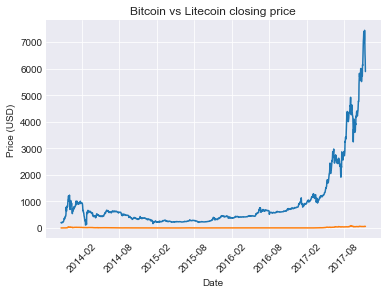

In [9]:
#
# Plot the two coins on the same plot.
#
sns.set_style("darkgrid")
plt.plot(df_coins.btc_close)
plt.plot(df_coins.ltc_close)
plt.xticks(rotation=45)
plt.title("Bitcoin vs Litecoin closing price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

### This plot isnt very helpful as the price difference between the two coins is too large to be shown without some normalization.

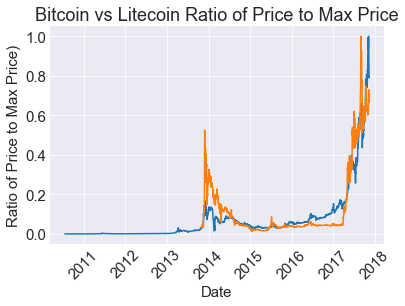

In [54]:
#
# Plot the two coins on the same plot but normalized.
#
sns.set_style("darkgrid")
plt.plot(df_coins.btc_close / df_coins.btc_close.max())
plt.plot(df_coins.ltc_close / df_coins.ltc_close.max())
plt.xticks(rotation=45)
plt.title("Bitcoin vs Litecoin Ratio of Price to Max Price")
plt.xlabel("Date")
plt.ylabel("Ratio of Price to Max Price)")
plt.show()

### Now that historical for both bitcoin and litecoin has been gathered and cleaned, the Google keyword search trend data needs to be obtained.

In [59]:
#
# Query Google for the keyword serach trend.
#
bitcoin = TrendReq()
litecoin = TrendReq()
btc_kwrd = ["bitcoin price"]
ltc_kwrd = ["litecoin price"]
bitcoin.build_payload(btc_kwrd)
litecoin.build_payload(ltc_kwrd)

#
# Obtain the intrest over time.  Resample by day and interpolate between points.
#
df_kwrd_bitcoin = bitcoin.interest_over_time()
df_kwrd_litecoin = litecoin.interest_over_time()

#
# Print the last 10 entries for bitcoin to understand what the dataframe looks like.
#
df_kwrd_bitcoin.tail(10)

,bitcoin price,isPartial
date,,
2017-09-03,58,False
2017-09-10,74,False
2017-09-17,52,False
2017-09-24,40,False
2017-10-01,35,False
2017-10-08,59,False
2017-10-15,63,False
2017-10-22,66,False
2017-10-29,94,False


### It appears that the data from Google is by week.  However, the price data is by day.  To remedy this problem the Google trend data will be intrepolated between weeks to obtain a daily estimate.  Also, the 'isPartial' feature is not needed so should be removed from the dataframe to keep it uncluttered.

In [60]:
df_kwrd_bitcoin = df_kwrd_bitcoin.resample('D').interpolate(method='linear')
df_kwrd_litecoin = df_kwrd_litecoin.resample('D').interpolate(method='linear')
del df_kwrd_bitcoin['isPartial']
del df_kwrd_litecoin['isPartial']

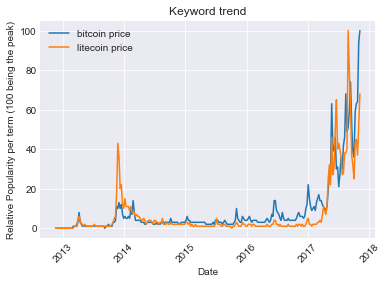

In [12]:
#
# Plot the two keywords on the same plot.
#
sns.set_style("darkgrid")
plt.plot(df_kwrd_bitcoin[btc_kwrd])
plt.plot(df_kwrd_litecoin[ltc_kwrd])
plt.legend([btc_kwrd[0], ltc_kwrd[0]])
plt.xticks(rotation=45)
plt.title("Keyword trend")
plt.xlabel("Date")
plt.ylabel("Relative Popularity per term (100 being the peak)")
plt.show()

In [13]:
#
# Instert the keyword search data into the df_coins dataframe.
#
df_coins['btc_kwrd'] = df_kwrd_bitcoin[btc_kwrd[0]]
df_coins['ltc_kwrd'] = df_kwrd_litecoin[ltc_kwrd[0]]

### The Google keyword search trend data is now properly in memory in one dataframe.  Some EDA will be performed to look for any trends that are worth further exploration.

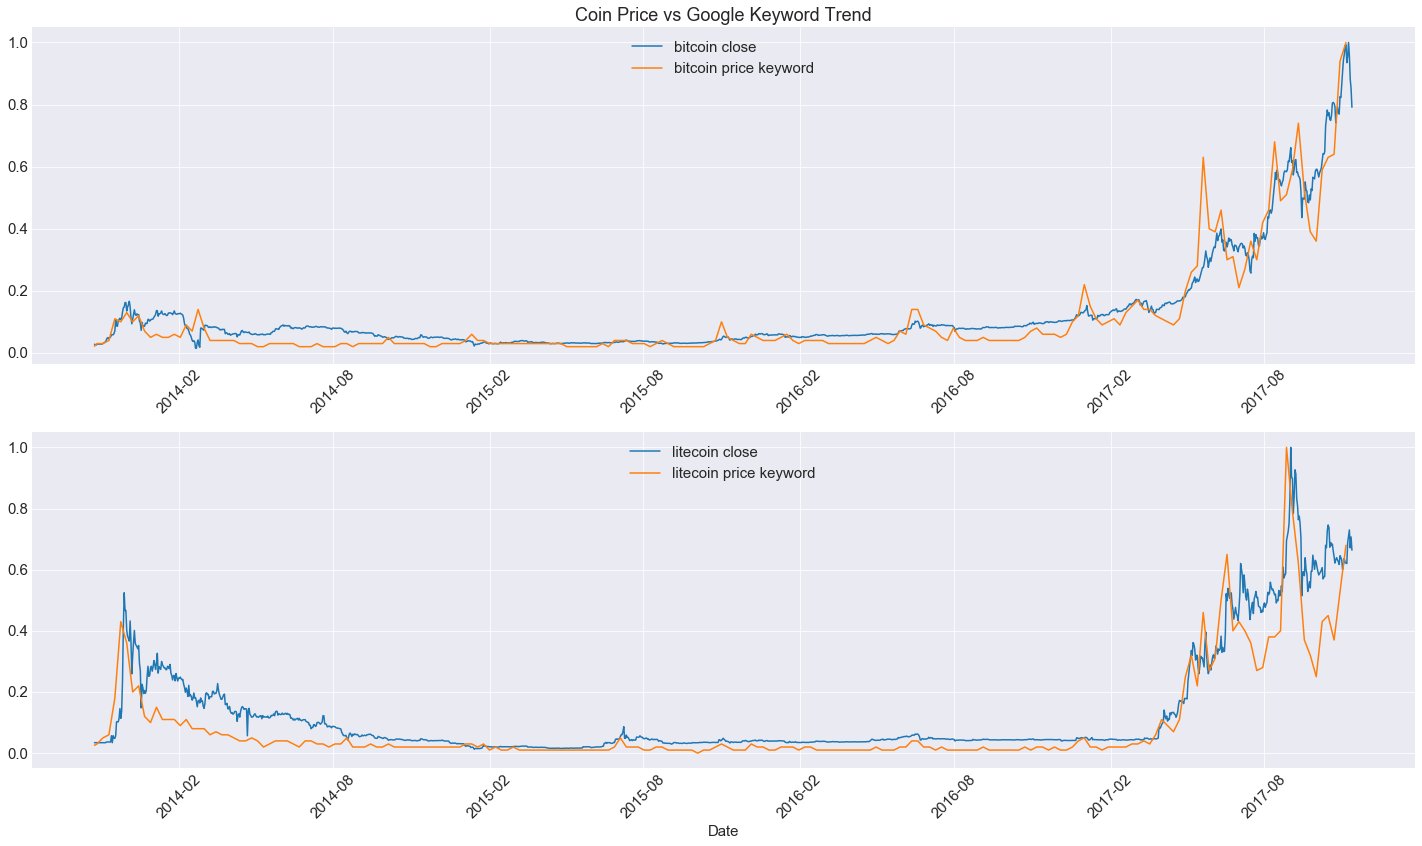

In [14]:
#
# Plot price vs keyword on the same plot.
#
plt.rcParams.update({'font.size': 15})
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(211)
plt.title("Coin Price vs Google Keyword Trend")
ax.plot(df_coins.btc_close / df_coins.btc_close.max())
ax.plot(df_coins.btc_kwrd / df_coins.btc_kwrd.max())
ax.legend(["bitcoin close", btc_kwrd[0] + " keyword"],loc="upper center")
plt.xticks(rotation=45)
ax = fig.add_subplot(212)
ax.plot(df_coins.ltc_close / df_coins.ltc_close.max())
ax.plot(df_coins.ltc_kwrd / df_coins.ltc_kwrd.max())
ax.legend(["litecoin close",  ltc_kwrd[0] + " keyword"], loc="upper center")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

### At first glance, the Google search trend data appears to be strongly coorelated with the price of its respective coin.  Also, the data does not appear to be very interesting before the year 2016 so only that data will explored further.  First, lets plot only that data.

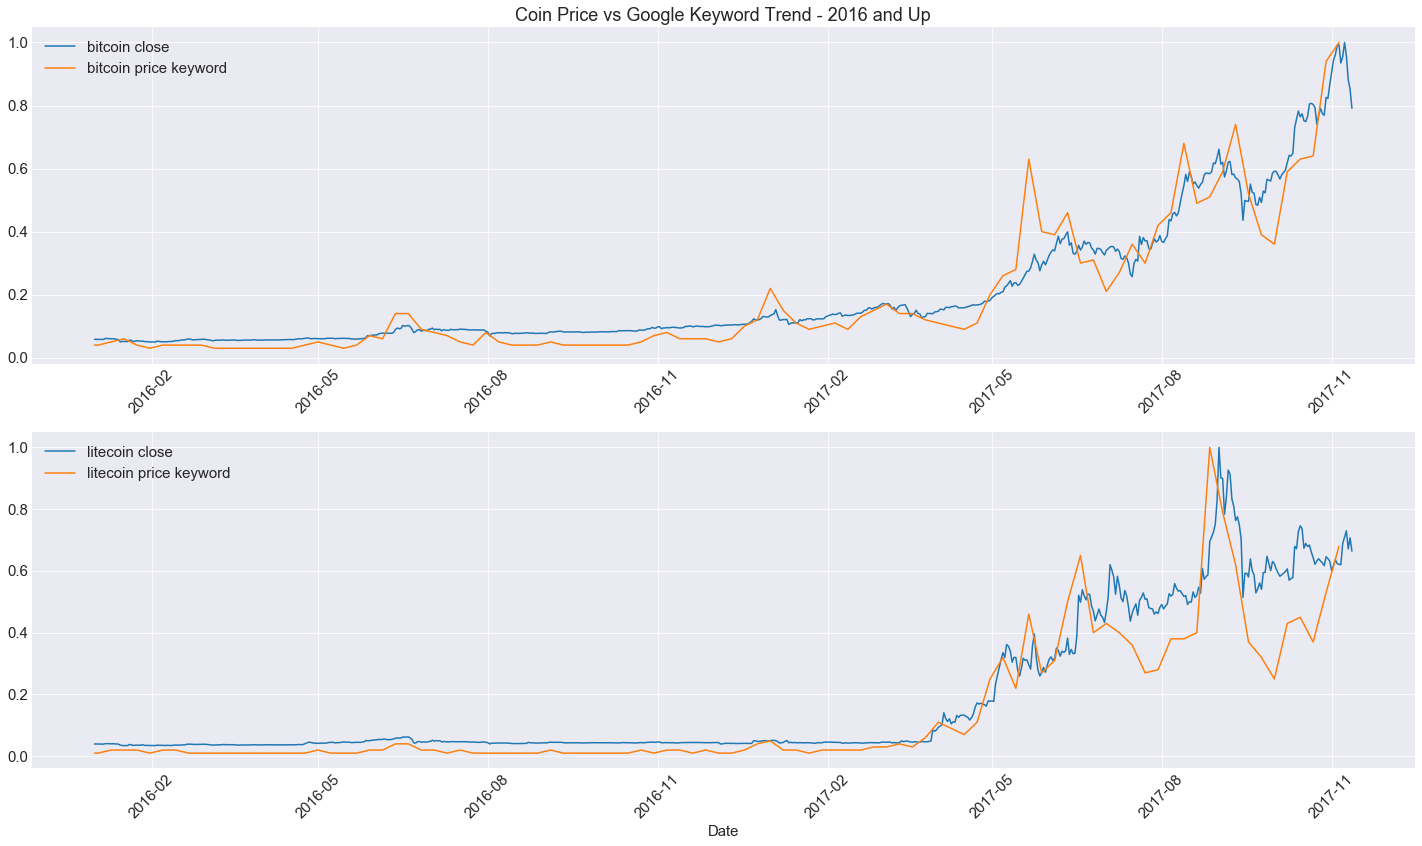

In [15]:
#
# Obtain 2016 and on.
#
year = '2016'

#
# Plot price vs keyword on the same plot for 2016 and on.
#
plt.rcParams.update({'font.size': 15})
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(211)
plt.title("Coin Price vs Google Keyword Trend - " + year + " and Up")
ax.plot(df_coins[year:].btc_close / df_coins[year:].btc_close.max())
ax.plot(df_coins[year:].btc_kwrd / df_coins[year:].btc_kwrd.max())
ax.legend(["bitcoin close", btc_kwrd[0] + " keyword"], loc="upper left")
plt.xticks(rotation=45)
ax = fig.add_subplot(212)
ax.plot(df_coins[year:].ltc_close / df_coins[year:].ltc_close.max())
ax.plot(df_coins[year:].ltc_kwrd / df_coins[year:].ltc_kwrd.max())
ax.legend(["litecoin close", ltc_kwrd[0] + " keyword"], loc="upper left")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Now that we know what that data looks like, the pearson coorelation coefficient will be examined to determine how strong coorelated the two datasets are.

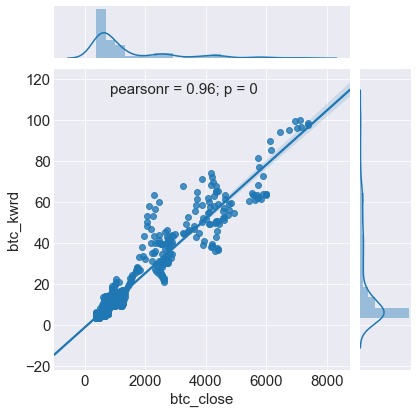

In [45]:
#
# How coorelated are the search term frequency with the closing price for bitcoin?
#
sns.jointplot(x="btc_close", y="btc_kwrd", data=df_coins[year:], kind="reg")

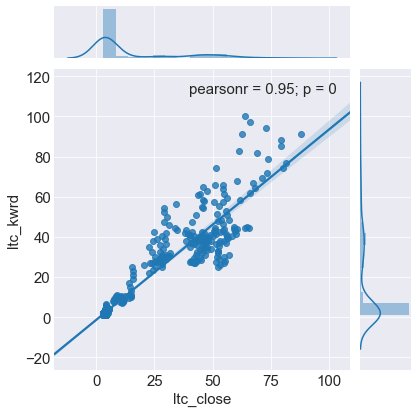

In [46]:
#
# How coorelated are the search term frequency with the closing price for litecoin?
#
sns.jointplot(x="ltc_close", y="ltc_kwrd", data=df_coins[year:], kind="reg")

### The coorelations are very strong between the search frequency and the closing price for both bitcoin and litecoin.  What happens if we shift the search term plot by one day, does the coorelations increase, decrease or remain the same?

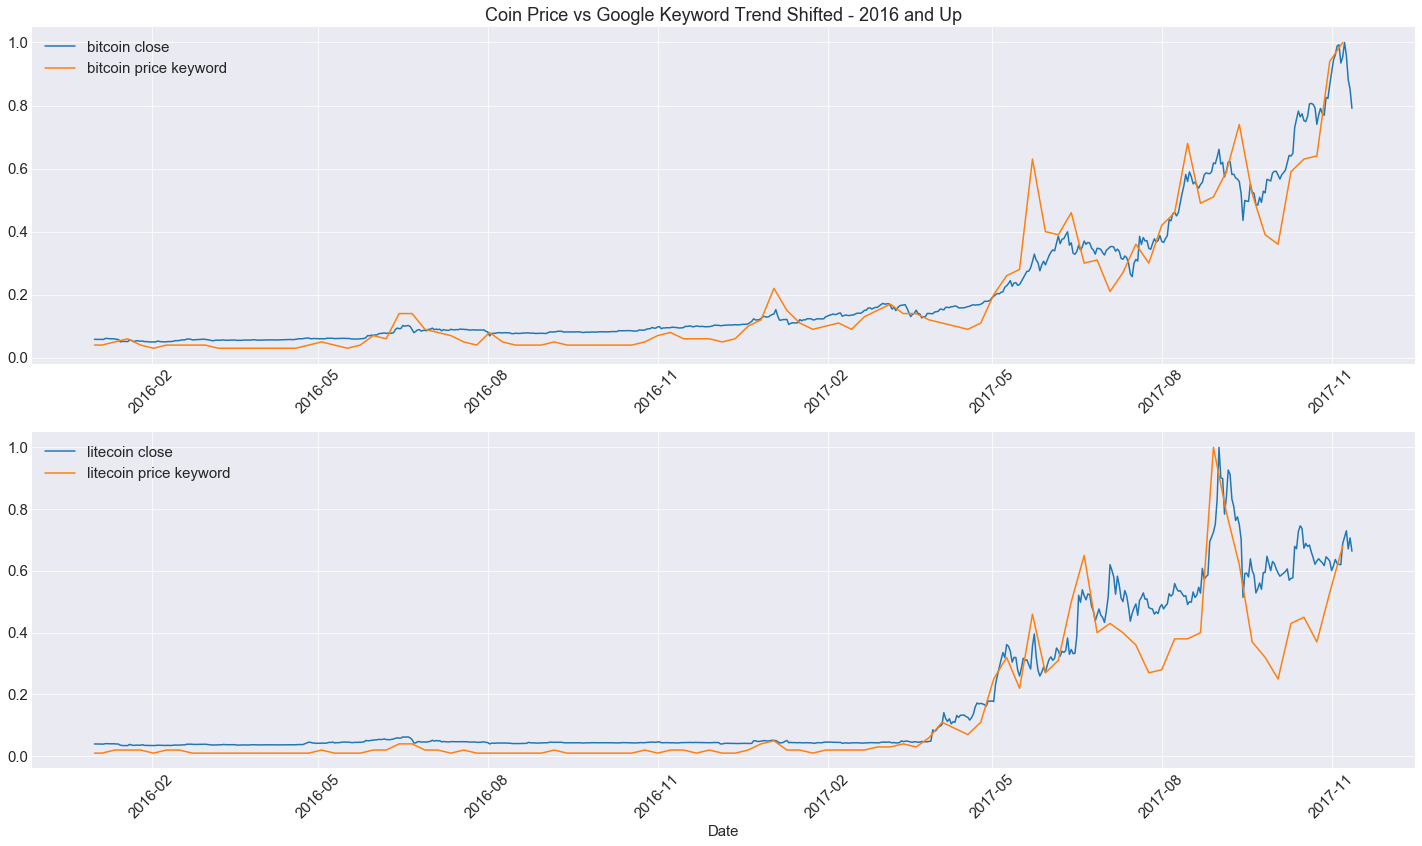

In [32]:
#
# Shift the search term vectors by a day.
#
df_coins_shifted = pd.DataFrame(df_coins)
df_coins_shifted.btc_kwrd = df_coins.btc_kwrd.shift(1)
df_coins_shifted.ltc_kwrd = df_coins.ltc_kwrd.shift(1)

#
# Plot price vs shifted keyword on the same plot for 2016 and on.
#
plt.rcParams.update({'font.size': 15})
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(211)
plt.title("Coin Price vs Google Keyword Trend Shifted - " + year + " and Up")
ax.plot(df_coins_shifted[year:].btc_close / df_coins_shifted[year:].btc_close.max())
ax.plot(df_coins_shifted[year:].btc_kwrd / df_coins_shifted[year:].btc_kwrd.max())
ax.legend(["bitcoin close", btc_kwrd[0] + " keyword"], loc="upper left")
plt.xticks(rotation=45)
ax = fig.add_subplot(212)
ax.plot(df_coins_shifted[year:].ltc_close / df_coins_shifted[year:].ltc_close.max())
ax.plot(df_coins_shifted[year:].ltc_kwrd / df_coins_shifted[year:].ltc_kwrd.max())
ax.legend(["litecoin close", ltc_kwrd[0] + " keyword"], loc="upper left")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

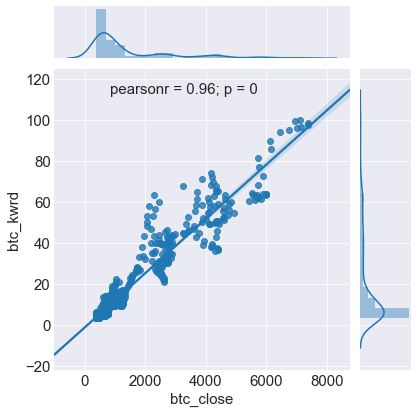

In [44]:
#
# How coorelated are the shifted search term frequency with the closing price for bitcoin?
#
sns.jointplot(x="btc_close", y="btc_kwrd", data=df_coins_shifted[year:], kind="reg")

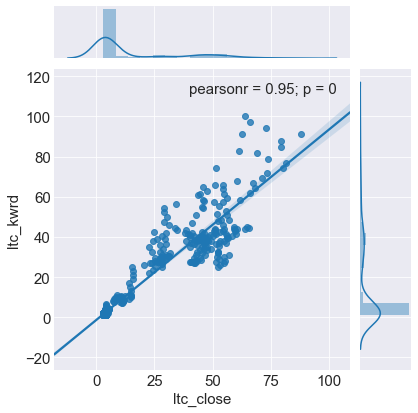

In [43]:
#
# How coorelated are the shifted search term frequency with the closing price for litcoin?
#
sns.jointplot(x="ltc_close", y="ltc_kwrd", data=df_coins_shifted[year:], kind="reg")

### Conclusion:
- Both coins remain very coorelated with the search term frequency even when they are shitfted by a day! Litecoin's coorelation actually increased from 0.93 to 0.95.  This is very interesting and would suggest that the search term frequency could potentially be used to predict the price direction for either coin.  From the r-squared value, 92.16% of the variance can be explained from the search term frequency for bitcoin even after a day delay.  For litecoin, 90.25% of the variance can be explained from the search term frequency also a day delayed.

- Further work could be performed to test the possibility of predicting the price of either coin from the search term trend using regression and/or machine learning algorithms.